In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-04-02 21:29:28.906252: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
labels = labels.astype(np.float64)

In [6]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually

In [7]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [8]:
import json

In [9]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [10]:
X_train = images[0:image_data['84']] 
y_train = labels[0:label_data['84']]
X_val = images[image_data['84']:]
y_val = labels[label_data['84']:]

In [11]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 512, 512, 1) (2, 512, 512, 1)


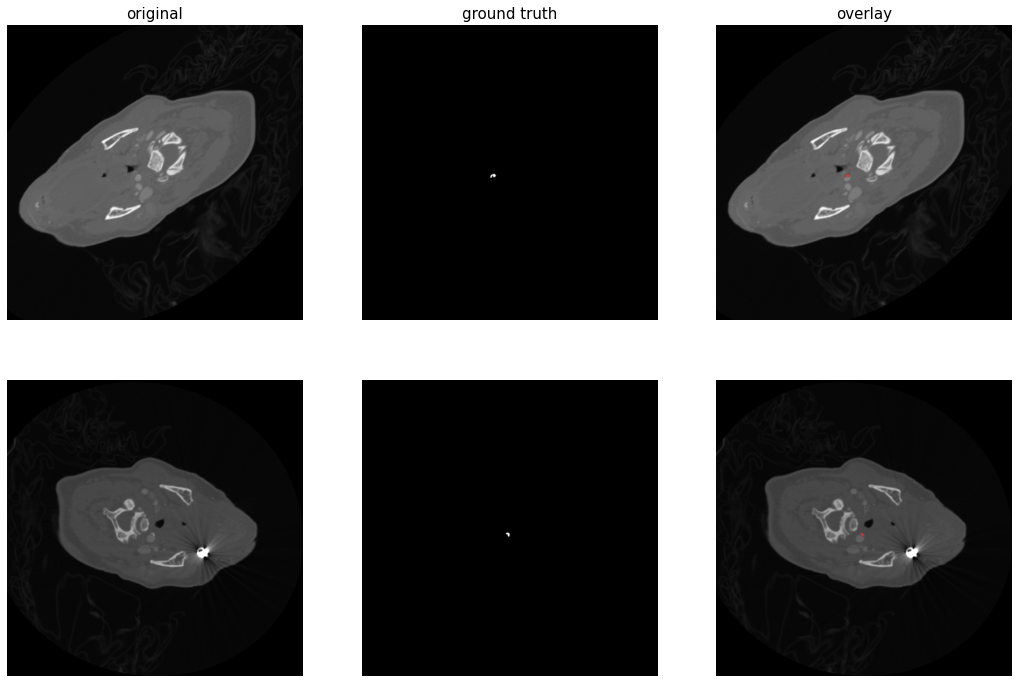

In [12]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)


In [13]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2, 
    dropout_change_per_layer=0.0,
    num_layers=4,
    output_activation='sigmoid')

2023-04-02 21:29:46.095553: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-02 21:29:46.244085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-02 21:29:46.244120: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-02 21:29:46.247035: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-02 21:29:46.247064: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-02 21:29:46.247884: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [14]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [15]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [16]:
history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // 32,
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-04-02 21:29:47.589032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-02 21:29:47.609178: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-02 21:29:48.756024: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-02 21:29:49.359988: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-02 21:29:50.011426: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-02 21:29:50.011447: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-02 21:29:50.011512: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-02 21:29:50.056300: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-02 21:29:50.893560: I tensorflow/stream_exec

19/19 [==============================] - 26s 991ms/step - loss: 0.1492 - iou: 0.0017 - iou_thresholded: 0.0081 - val_loss: 0.0403 - val_iou: 1.7148e-05 - val_iou_thresholded: 3.3159e-04
Epoch 2/200
19/19 [==============================] - 3s 153ms/step - loss: 0.0143 - iou: 0.0037 - iou_thresholded: 0.0076 - val_loss: 0.0084 - val_iou: 1.9060e-04 - val_iou_thresholded: 3.3159e-04
Epoch 3/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0068 - iou: 0.0039 - iou_thresholded: 0.0089 - val_loss: 0.0066 - val_iou: 3.9605e-04 - val_iou_thresholded: 3.3159e-04
Epoch 4/200
19/19 [==============================] - 3s 152ms/step - loss: 0.0050 - iou: 0.0029 - iou_thresholded: 0.0070 - val_loss: 0.0066 - val_iou: 3.0939e-04 - val_iou_thresholded: 3.3159e-04
Epoch 5/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0057 - iou: 0.0024 - iou_thresholded: 0.0053 - val_loss: 0.0064 - val_iou: 4.6428e-04 - val_iou_thresholded: 3.3159e-04
Epoch 6/200
19/19 [=======

19/19 [==============================] - 3s 151ms/step - loss: 0.0039 - iou: 0.0077 - iou_thresholded: 0.0067 - val_loss: 0.0038 - val_iou: 0.0135 - val_iou_thresholded: 3.3159e-04
Epoch 44/200
19/19 [==============================] - 3s 156ms/step - loss: 0.0024 - iou: 0.0082 - iou_thresholded: 0.0084 - val_loss: 0.0035 - val_iou: 0.0109 - val_iou_thresholded: 3.3159e-04
Epoch 45/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0032 - iou: 0.0083 - iou_thresholded: 0.0066 - val_loss: 0.0036 - val_iou: 0.0154 - val_iou_thresholded: 3.3159e-04
Epoch 46/200
19/19 [==============================] - 3s 153ms/step - loss: 0.0031 - iou: 0.0078 - iou_thresholded: 0.0096 - val_loss: 0.0045 - val_iou: 0.0053 - val_iou_thresholded: 3.3159e-04
Epoch 47/200
19/19 [==============================] - 3s 152ms/step - loss: 0.0028 - iou: 0.0147 - iou_thresholded: 0.0078 - val_loss: 0.0036 - val_iou: 0.0175 - val_iou_thresholded: 3.3159e-04
Epoch 48/200
19/19 [=======================

Epoch 86/200
19/19 [==============================] - 3s 153ms/step - loss: 0.0020 - iou: 0.0870 - iou_thresholded: 0.0885 - val_loss: 0.0025 - val_iou: 0.0999 - val_iou_thresholded: 0.2213
Epoch 87/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0017 - iou: 0.1316 - iou_thresholded: 0.2355 - val_loss: 0.0022 - val_iou: 0.1580 - val_iou_thresholded: 0.3062
Epoch 88/200
19/19 [==============================] - 3s 152ms/step - loss: 0.0027 - iou: 0.0723 - iou_thresholded: 0.1129 - val_loss: 0.0027 - val_iou: 0.1133 - val_iou_thresholded: 0.2897
Epoch 89/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0026 - iou: 0.0697 - iou_thresholded: 0.1151 - val_loss: 0.0030 - val_iou: 0.0939 - val_iou_thresholded: 0.3154
Epoch 90/200
19/19 [==============================] - 3s 153ms/step - loss: 0.0025 - iou: 0.0335 - iou_thresholded: 0.0281 - val_loss: 0.0024 - val_iou: 0.0861 - val_iou_thresholded: 0.1090
Epoch 91/200
19/19 [==============================

Epoch 129/200
19/19 [==============================] - 3s 152ms/step - loss: 0.0014 - iou: 0.2792 - iou_thresholded: 0.3847 - val_loss: 0.0018 - val_iou: 0.3403 - val_iou_thresholded: 0.4635
Epoch 130/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0017 - iou: 0.1713 - iou_thresholded: 0.2655 - val_loss: 0.0020 - val_iou: 0.2614 - val_iou_thresholded: 0.4169
Epoch 131/200
19/19 [==============================] - 3s 149ms/step - loss: 0.0018 - iou: 0.0440 - iou_thresholded: 0.0689 - val_loss: 0.0022 - val_iou: 0.1569 - val_iou_thresholded: 0.2034
Epoch 132/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0020 - iou: 0.0844 - iou_thresholded: 0.1021 - val_loss: 0.0020 - val_iou: 0.1695 - val_iou_thresholded: 0.3126
Epoch 133/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0016 - iou: 0.2584 - iou_thresholded: 0.3446 - val_loss: 0.0033 - val_iou: 0.2885 - val_iou_thresholded: 0.3707
Epoch 134/200
19/19 [========================

Epoch 172/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0024 - iou: 0.2004 - iou_thresholded: 0.3634 - val_loss: 0.0018 - val_iou: 0.2976 - val_iou_thresholded: 0.4579
Epoch 173/200
19/19 [==============================] - 3s 152ms/step - loss: 0.0013 - iou: 0.2206 - iou_thresholded: 0.3450 - val_loss: 0.0017 - val_iou: 0.2989 - val_iou_thresholded: 0.4691
Epoch 174/200
19/19 [==============================] - 3s 151ms/step - loss: 9.6413e-04 - iou: 0.2045 - iou_thresholded: 0.2763 - val_loss: 0.0017 - val_iou: 0.4189 - val_iou_thresholded: 0.4754
Epoch 175/200
19/19 [==============================] - 3s 151ms/step - loss: 0.0013 - iou: 0.2341 - iou_thresholded: 0.2864 - val_loss: 0.0033 - val_iou: 0.0523 - val_iou_thresholded: 0.0297
Epoch 176/200
19/19 [==============================] - 3s 152ms/step - loss: 0.0027 - iou: 0.1191 - iou_thresholded: 0.1746 - val_loss: 0.0022 - val_iou: 0.2598 - val_iou_thresholded: 0.3782
Epoch 177/200
19/19 [====================

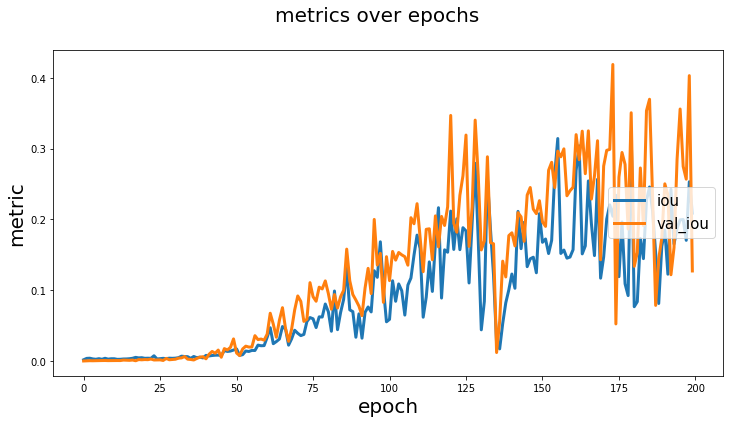

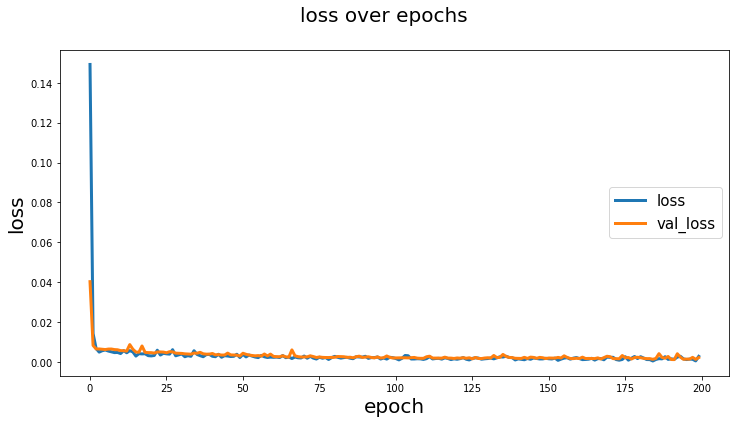

In [17]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [18]:
y_pred = model.predict(X_val)

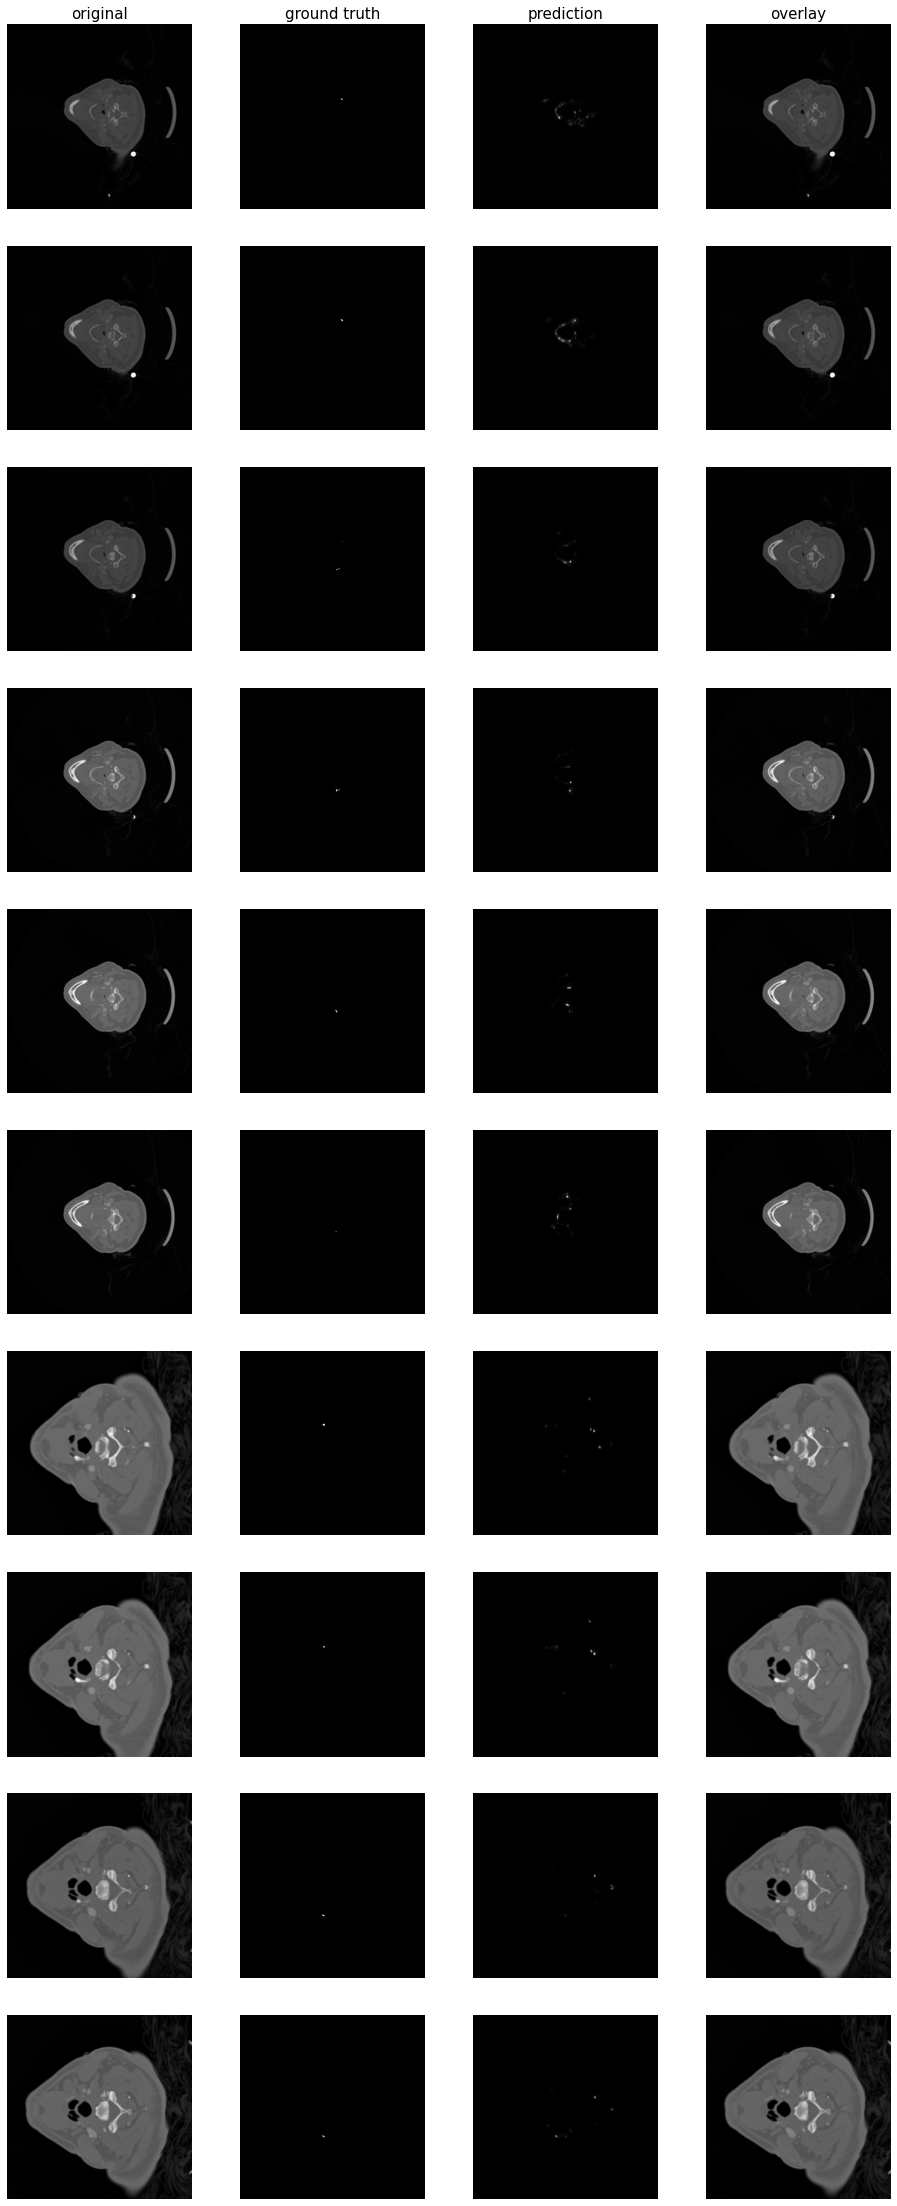

In [19]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [20]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 1s 193ms/step - loss: 0.0023 - iou: 0.1272 - iou_thresholded: 0.0896
